# Canvas Creation

First, read about the [Canvas overview](Canvas-Overview.ipynb).

Skia has multiple backends which receive `Canvas` drawing commands, including:

- [Raster](#Raster) - CPU-only.
- [GPU](#GPU) - Skia's GPU-accelerated backend.
- [PDF](#PDF) - PDF document creation.
- [Picture](#Picture) - Skia's display list format.
- [NullCanvas](#NullCanvas) - Useful for testing only.
- XPS - Experimental XPS backend.
- SVG - Experimental SVG backend.

Each backend has a unique way of creating a Canvas. This page gives an example for each:

In [1]:
import skia
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Image
%matplotlib inline


def draw(canvas):
    canvas.clear(skia.ColorWHITE)
    paint = skia.Paint()
    paint.setAntiAlias(True)
    paint.setColor(skia.ColorGREEN)
    canvas.drawCircle(100., 100., 40., paint)

## Raster

The raster backend draws to a block of memory. This memory can be managed by Skia or by the client.

The recommended way of creating a canvas for the Raster and Ganesh backends is to use a `Surface`, which is an object that manages the memory into which the canvas commands are drawn.

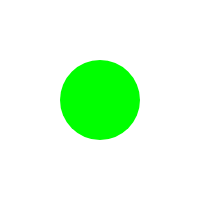

In [2]:
def raster(width, height):
    surface = skia.Surface.MakeRasterN32Premul(width, height)
    canvas = surface.getCanvas()
    draw(canvas)
    image = surface.makeImageSnapshot()
    assert image is not None
    png = image.encodeToData()
    display(Image(data=png))


raster(200, 200)

Alternatively, we could have specified the memory for the surface explicitly, instead of asking Skia to manage it.

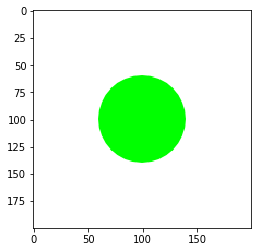

In [3]:
def raster_direct(width, height):
    array = np.zeros((height, width, 4), dtype=np.uint8)  # Allocate array here
    surface = skia.Surface(array)
    canvas = surface.getCanvas()
    draw(canvas)
    plt.imshow(array)
    plt.show()
    
    
raster_direct(200, 200)

## GPU

GPU Surfaces must have a `GrContext` object which manages the GPU context, and related caches for textures and fonts. GrContexts are matched one to one with OpenGL contexts or Vulkan devices. That is, all `Surface` that will be rendered to using the same OpenGL context or Vulkan device should share a `GrContext`. Skia does not create a OpenGL context or Vulkan device for you. In OpenGL mode it also assumes that the correct OpenGL context has been made current to the current thread when Skia calls are made.

The following example uses `glfw` package to create an OpenGL context. Install `glfw` via pip to try.

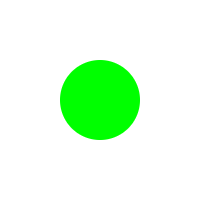

In [4]:
import glfw
import contextlib


@contextlib.contextmanager
def glfw_context():
    if not glfw.init():
        raise RuntimeError('glfw.init() failed')
    glfw.window_hint(glfw.VISIBLE, glfw.FALSE)
    glfw.window_hint(glfw.STENCIL_BITS, 8)
    window = glfw.create_window(640, 480, '', None, None)
    glfw.make_context_current(window)
    yield window
    glfw.terminate()

    
def gl_example(width, height):
    context = skia.GrContext.MakeGL()
    info = skia.ImageInfo.MakeN32Premul(width, height)
    surface = skia.Surface.MakeRenderTarget(context, skia.Budgeted.kNo, info)
    assert surface is not None
    canvas = surface.getCanvas()
    draw(canvas)
    image = surface.makeImageSnapshot()
    assert image is not None
    png = image.encodeToData()
    display(Image(data=png))
    

with glfw_context():
    gl_example(200, 200)

## PDF

The `PDF` backend uses `Document` instead of `Surface`, since a document must include multiple pages.

In [5]:
def pdf(width, height, path):
    stream = skia.FILEWStream(path)
    document = skia.PDF.MakeDocument(stream)
    canvas = document.beginPage(width, height)
    draw(canvas)
    document.endPage()
    document.close()
    

pdf(200, 200, 'output.pdf')

## Picture

The `Picture` backend uses `PictureRecorder` instead of `Surface`.

In [6]:
def picture(width, height):
    recorder = skia.PictureRecorder()
    canvas = recorder.beginRecording(width, height)
    draw(canvas)
    picture = recorder.finishRecordingAsPicture()
    data = picture.serialize()
    
    
picture(200, 200)

## NullCanvas

The null canvas is a canvas that ignores all drawing commands and does nothing.

In [7]:
def null_canvas_example(width, height):
    canvas = skia.MakeNullCanvas()
    draw(canvas)  # No op
    
    
null_canvas_example(200, 200)